In [21]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Sep  15 08:50:58 2021
@author: zeqinhuang
"""

import xarray as xr
import numpy as np
import pandas as pd
import os
import proplot as pplot
import cmaps
from matplotlib import pyplot as plt
from scipy.stats import norm
import glob
import matplotlib as mpl
import xesmf as xe
from cartopy.util import add_cyclic_point
from scipy.stats import linregress
from scipy.stats import theilslopes
import geopandas as gp
import seaborn as sns
import random
from warnings import simplefilter

import matplotlib.patches as pch
import cartopy
import cartopy.crs as ccrs
mapcrs = ccrs.PlateCarree(central_longitude=0, globe=None)
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from utils import *

simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)


In [2]:
hadex_rx1day = xr.open_dataset('/Users/zeqinhuang/Documents/paper/prec_scaling_da/scaling_script/HadEX3/HadEX3-0-4_rx1day_ann.nc')
hadex_rx1day = hadex_rx1day['Rx1day']
hadex_rx1day = hadex_rx1day.rename({'longitude':'lon','latitude':'lat'})
hadex_rx1day = hadex_rx1day.sel(time=slice('1960','2014'))
hadex_rx1day_sel = hadex_rx1day * hadex_rx1day_grid_sel

In [3]:
hadex_rx1day_clim = hadex_rx1day_sel.mean(axis=0,skipna=True)

era5_prec_hist = Rx1dayCond('prec','era5','era5','reanalysis',mask='None')
era5_prec_hist = era5_prec_hist.regrid()
era5_prec_hist = era5_prec_hist.sel(time=slice('1960','2014'))
era5_prec_hist = era5_prec_hist['prec_cond'].mean(axis=0,skipna=True)
era5_prec_spatial_cor = xr.corr(era5_prec_hist,hadex_rx1day_clim).values.tolist()

era5_scaling_hist = Rx1dayCond('scaling','era5','era5','reanalysis',mask='None')
era5_scaling_hist = era5_scaling_hist.regrid()
era5_scaling_hist = era5_scaling_hist.sel(time=slice('1960','2014'))
era5_scaling_hist = era5_scaling_hist['scaling'].mean(axis=0,skipna=True)
era5_scaling_spatial_cor = xr.corr(era5_scaling_hist,hadex_rx1day_clim).values.tolist()

jra55_prec_hist = Rx1dayCond('prec','jra55','jra55','reanalysis',mask='None')
jra55_prec_hist = jra55_prec_hist.regrid()
jra55_prec_hist = jra55_prec_hist.sel(time=slice('1960','2014'))
jra55_prec_hist = jra55_prec_hist['prec_cond'].mean(axis=0,skipna=True)
jra55_prec_spatial_cor = xr.corr(jra55_prec_hist,hadex_rx1day_clim).values.tolist()

jra55_scaling_hist = Rx1dayCond('scaling','jra55','jra55','reanalysis',mask='None')
jra55_scaling_hist = jra55_scaling_hist.regrid()
jra55_scaling_hist = jra55_scaling_hist.sel(time=slice('1960','2014'))
jra55_scaling_hist = jra55_scaling_hist['scaling'].mean(axis=0,skipna=True)
jra55_scaling_spatial_cor = xr.corr(jra55_scaling_hist,hadex_rx1day_clim).values.tolist()

name_ens = 'prec'
forcing_ens = 'historical'
ensemble     = ensembles[forcing_ens]
ensemble     = [i+'_'+filepath[-12:-3] for i in ensemble for filepath in glob.glob(forcing_dir[forcing_ens] + name_ens + '_day_' + i + '*.nc')]
prec_hist_mme = np.zeros(shape=(len(ensemble),hadex_rx1day_grid_sel.shape[0],hadex_rx1day_grid_sel.shape[1]))

prec_hist_spatial_cor = []
scaling_hist_spatial_cor = []

for x in range(len(ensemble)):
    i = ensemble[x]
    src_id = i.split('_')[0]
    run    = i.split('_')[2]
    pi_time = i.split('_')[3]
    ens_i  = Rx1dayCond('prec',forcing_ens,src_id,run,mask='Global',pi_time=pi_time)
    ens_i_regrid = ens_i.regrid()
    ens_i_regrid = ens_i_regrid.sel(time=slice('1960','2014'))
    ens_i_regrid = ens_i_regrid['prec_cond']
    ens_i_regrid = ens_i_regrid.mean(axis=0,skipna=True)
    prec_hist_spatial_cor.append(xr.corr(ens_i_regrid, hadex_rx1day_clim).values.tolist())

for x in range(len(ensemble)):
    i = ensemble[x]
    src_id = i.split('_')[0]
    run    = i.split('_')[2]
    pi_time = i.split('_')[3]
    ens_i  = Rx1dayCond('scaling',forcing_ens,src_id,run,mask='Global',pi_time=pi_time)
    ens_i_regrid = ens_i.regrid()
    ens_i_regrid = ens_i_regrid.sel(time=slice('1960','2014'))
    ens_i_regrid = ens_i_regrid['scaling']
    ens_i_regrid = ens_i_regrid.mean(axis=0,skipna=True)
    ens_i_cor = xr.corr(ens_i_regrid, hadex_rx1day_clim).values.tolist()
    scaling_hist_spatial_cor.append(ens_i_cor)

In [18]:
def spatial_cor_for_mask_reanalyses(mask):
    hadex_rx1day_clim = hadex_rx1day_sel.mean(axis=0,skipna=True)
    hadex_rx1day_clim_mask = hadex_rx1day_clim * mask
    
    era5_prec_hist = Rx1dayCond('prec','era5','era5','reanalysis',mask='None')
    era5_prec_hist = era5_prec_hist.regrid()
    era5_prec_hist = era5_prec_hist.sel(time=slice('1960','2014'))
    era5_prec_hist = era5_prec_hist['prec_cond'].mean(axis=0,skipna=True)
    era5_prec_hist_mask = era5_prec_hist * mask
    era5_prec_spatial_cor = xr.corr(era5_prec_hist_mask,hadex_rx1day_clim_mask).values.tolist()

    era5_scaling_hist = Rx1dayCond('scaling','era5','era5','reanalysis',mask='None')
    era5_scaling_hist = era5_scaling_hist.regrid()
    era5_scaling_hist = era5_scaling_hist.sel(time=slice('1960','2014'))
    era5_scaling_hist = era5_scaling_hist['scaling'].mean(axis=0,skipna=True)
    era5_scaling_hist_mask = era5_scaling_hist * mask
    era5_scaling_spatial_cor = xr.corr(era5_scaling_hist_mask,hadex_rx1day_clim_mask).values.tolist()

    jra55_prec_hist = Rx1dayCond('prec','jra55','jra55','reanalysis',mask='None')
    jra55_prec_hist = jra55_prec_hist.regrid()
    jra55_prec_hist = jra55_prec_hist.sel(time=slice('1960','2014'))
    jra55_prec_hist = jra55_prec_hist['prec_cond'].mean(axis=0,skipna=True)
    jra55_prec_hist_mask = jra55_prec_hist * mask
    jra55_prec_spatial_cor = xr.corr(jra55_prec_hist_mask,hadex_rx1day_clim_mask).values.tolist()

    jra55_scaling_hist = Rx1dayCond('scaling','jra55','jra55','reanalysis',mask='None')
    jra55_scaling_hist = jra55_scaling_hist.regrid()
    jra55_scaling_hist = jra55_scaling_hist.sel(time=slice('1960','2014'))
    jra55_scaling_hist = jra55_scaling_hist['scaling'].mean(axis=0,skipna=True)
    jra55_scaling_hist_mask = jra55_scaling_hist * mask
    jra55_scaling_spatial_cor = xr.corr(jra55_scaling_hist_mask,hadex_rx1day_clim_mask).values.tolist()

    return era5_prec_spatial_cor, era5_scaling_spatial_cor, jra55_prec_spatial_cor, jra55_scaling_spatial_cor

def spatial_cor_for_mask_model(mask):
    name_ens = 'prec'
    forcing_ens = 'historical'
    ensemble     = ensembles[forcing_ens]
    ensemble     = [i+'_'+filepath[-12:-3] for i in ensemble for filepath in glob.glob(forcing_dir[forcing_ens] + name_ens + '_day_' + i + '*.nc')]

    prec_hist_spatial_cor_mask = []
    scaling_hist_spatial_cor_mask = []

    hadex_rx1day_clim = hadex_rx1day_sel.mean(axis=0,skipna=True)
    hadex_rx1day_clim_mask = hadex_rx1day_clim * mask

    for x in range(len(ensemble)):
        i = ensemble[x]
        src_id = i.split('_')[0]
        run    = i.split('_')[2]
        pi_time = i.split('_')[3]
        ens_i  = Rx1dayCond('prec',forcing_ens,src_id,run,mask='Global',pi_time=pi_time)
        ens_i_regrid = ens_i.regrid()
        ens_i_regrid = ens_i_regrid.sel(time=slice('1960','2014'))
        ens_i_regrid = ens_i_regrid['prec_cond']
        ens_i_regrid = ens_i_regrid.mean(axis=0,skipna=True)
        ens_i_regrid_mask = ens_i_regrid * mask
        prec_hist_spatial_cor_mask.append(xr.corr(ens_i_regrid_mask, hadex_rx1day_clim_mask).values.tolist())

    for x in range(len(ensemble)):
        i = ensemble[x]
        src_id = i.split('_')[0]
        run    = i.split('_')[2]
        pi_time = i.split('_')[3]
        ens_i  = Rx1dayCond('scaling',forcing_ens,src_id,run,mask='Global',pi_time=pi_time)
        ens_i_regrid = ens_i.regrid()
        ens_i_regrid = ens_i_regrid.sel(time=slice('1960','2014'))
        ens_i_regrid = ens_i_regrid['scaling']
        ens_i_regrid = ens_i_regrid.mean(axis=0,skipna=True)
        ens_i_regrid_mask = ens_i_regrid * mask
        ens_i_cor = xr.corr(ens_i_regrid_mask, hadex_rx1day_clim_mask).values.tolist()
        scaling_hist_spatial_cor_mask.append(ens_i_cor)

    return prec_hist_spatial_cor_mask, scaling_hist_spatial_cor_mask

In [4]:
ensemble_names = [i.split('_')[0] + '_' + i.split('_')[2] for i in ensemble]
prec_scaling_hist_spatial_cor = pd.DataFrame({'Rx1day':prec_hist_spatial_cor,'Scaling':scaling_hist_spatial_cor},index=ensemble_names)

prec_scaling_hist_spatial_cor_model = prec_scaling_hist_spatial_cor.copy()
prec_scaling_hist_spatial_cor_model['model'] = [i.split('_')[0] for i in ensemble]
prec_scaling_hist_spatial_cor_model = prec_scaling_hist_spatial_cor_model.groupby('model').mean()

/opt/anaconda3/envs/proenv/lib/python3.8/site-packages/proplot/axes/plot.py:1275: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  obj = getattr(super(), name)(*args, **kwargs)
/opt/anaconda3/envs/proenv/lib/python3.8/site-packages/proplot/axes/plot.py:1275: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('2').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  obj = getattr(super(), name)(*args, **kwargs)
/opt/anaconda3/envs/proenv/lib/python3.8/site-packages/proplot/axes/plot.py:1275: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('3').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  obj = getattr(super(), name)(*args, **kwargs)
/opt/anaconda3/envs/proenv/lib/

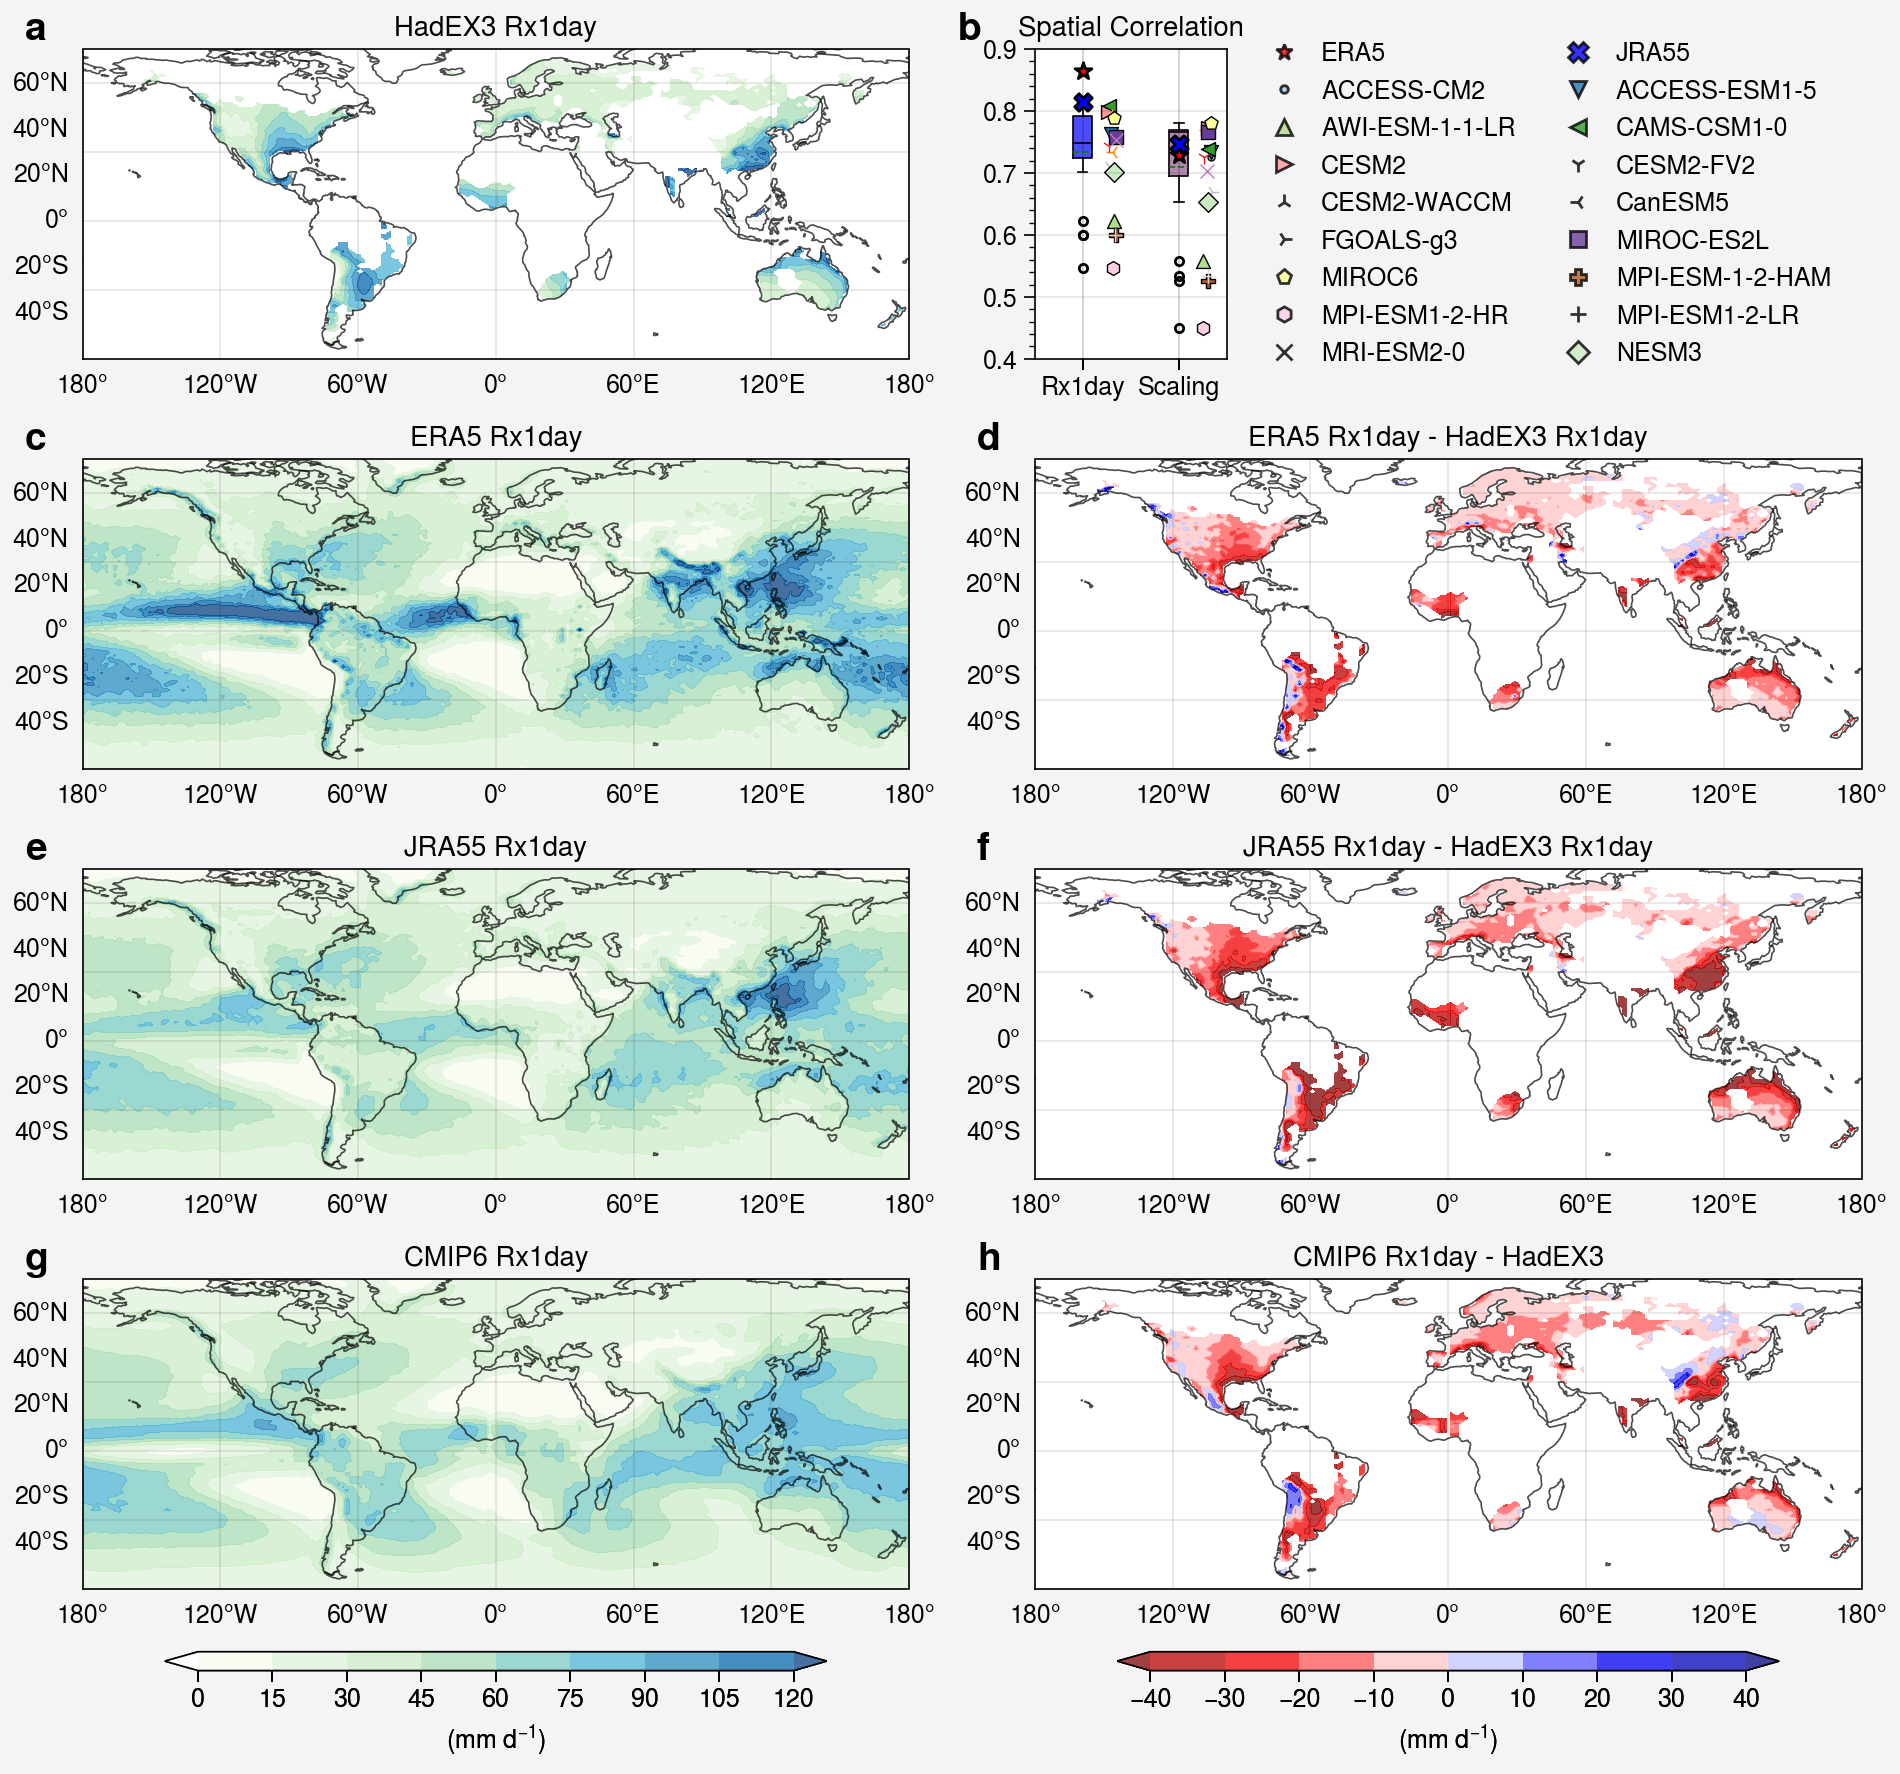

In [11]:
array = [[1,1,1,2,0,0],[3,3,3,4,4,4],[5,5,5,6,6,6],[7,7,7,8,8,8]]
fig, axs = pplot.subplots(array,wspace=(5),hspace=(4,4,4),proj={1:'pcarree',3:'pcarree',4:'pcarree',5:'pcarree',6:'pcarree',7:'pcarree',8:'pcarree',},width = 12,share=False)

def add_panel_label(ax, label, x = -0.1, y = 1):
    ax.text(x, y, label, transform=ax.transAxes,
      fontsize=14, fontweight='bold', va='top', ha='left')

vmax = 120
vmin = 0
vmax1 = 40
vmin1 = -40
vmax2 = 1.45
vmin2 = 0.55
levels = 10
cmap0 = cmaps.CBR_wet
cmap2 = cmaps.BlWhRe_r
cmap1 = cmaps.MPL_BrBG

marker_model = ['.','v','^','<','>','1','2','3','4','s','p','P','h','+','x','D','d']
marker_color = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928','#fccde5','#d9d9d9','#bc80bd','#ccebc5','#ffed6f']

hadex_region = shpreader.Reader('/Users/zeqinhuang/Documents/paper/prec_scaling_da/scaling_script/plotScript/scaling_plot_NW/shapefile/hadex_region.shp')
hadex_feature = ShapelyFeature(hadex_region.geometries(), ccrs.PlateCarree(central_longitude=0, globe=None), facecolor='none', edgecolor='black', lw=0.8)

# row1,col1 for Hadex3 Rx1day
ax1 = axs[0]
hadex_rx1day_clim = hadex_rx1day_sel.mean(axis=0,skipna=True)
lons1d = hadex_rx1day_clim['lon']
lats1d = hadex_rx1day_clim['lat']
data1_hadex  = hadex_rx1day_clim
data1_hadex, lons1d = add_cyclic_point(data1_hadex, coord=lons1d)
p1 = ax1.contourf(lons1d,lats1d,data1_hadex,levels = [i for i in np.linspace(vmin,vmax,9)],alpha=0.75,extend = 'both',cmap=cmap0)
ax1.set_title('HadEX3 Rx1day')
ax1.set(ylim=(-60,75))

resol = '110m' 
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale=resol, edgecolor='k', facecolor='none', alpha=0.7)
ax1.add_feature(land, facecolor='none')
add_panel_label(ax1, 'a', x=-0.07, y = 1.12)
gl = ax1.gridlines(draw_labels=True,)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False

# row1,col2 for spatial correlaiton
ax2 = axs[1]
ax2.box(prec_scaling_hist_spatial_cor, means=True,marker='.',meancolor='green',cycle=['blue','purple'],alpha=0.7,widths = 0.2)
ax2.scatter(x=0,y=era5_prec_spatial_cor,markers='*',edgecolors='black',s=40,facecolors='red',linewidth=1,zorder=10)
ax2.scatter(x=1,y=era5_scaling_spatial_cor,markers='*',edgecolors='black',s=40,facecolors='red',linewidth=1,zorder=10)
ax2.scatter(x=0,y=jra55_prec_spatial_cor,markers='X',edgecolors='black',s=40,facecolors='blue',linewidth=1,zorder=10)
ax2.scatter(x=1,y=jra55_scaling_spatial_cor,markers='X',edgecolors='black',s=40,facecolors='blue',linewidth=1,zorder=10)

ax2.set_ylim([0.4,0.9])
ax2.set_title('Spatial Correlation')
for i in range(len(prec_scaling_hist_spatial_cor_model.index)):
    m = prec_scaling_hist_spatial_cor_model.index[i]
    ax2.scatter(x = 0.3 + random.uniform(-0.05,0.05), y = prec_scaling_hist_spatial_cor_model.loc[m][0], marker = marker_model[i], edgecolors='black',s=25,facecolors=marker_color[i],linewidth=0.5)
    ax2.scatter(x = 1.3 + random.uniform(-0.05,0.05), y = prec_scaling_hist_spatial_cor_model.loc[m][1], marker = marker_model[i], edgecolors='black',s=25,facecolors=marker_color[i],linewidth=0.5)

legend_elements = [Line2D([], [], marker='*' ,color='none',markerfacecolor='red', label='ERA5',alpha=0.8,markersize=6),
    Line2D([], [], marker='X' ,color='none',markerfacecolor='blue', label='JRA55',alpha=0.8,markersize=7)]
for i in range(len(prec_scaling_hist_spatial_cor_model.index)):
    legend_elements.append(
        Line2D([], [], marker=marker_model[i],color='none',markerfacecolor=marker_color[i], 
        label=prec_scaling_hist_spatial_cor_model.index[i],alpha=0.8,markersize=5.5))
handles = legend_elements
ax2.legend(handles,['ERA5'].append(prec_scaling_hist_spatial_cor_model.index),frameon=False,ncol=2,bbox_to_anchor=(1.1,0.5),loc='center left',bbox_transform=ax2.transAxes)
add_panel_label(ax2, 'b', x=-0.4, y = 1.12)

# row2,col1 for ERA5
ax3 = axs[2]
era5_prec_hist = Rx1dayCond('prec','era5','era5','reanalysis',mask='None')
era5_prec_hist = era5_prec_hist.regrid()
era5_prec_hist = era5_prec_hist.sel(time=slice('1960','2014'))
era5_prec_hist = era5_prec_hist['prec_cond'].mean(axis=0,skipna=True)
lons1d = era5_prec_hist['lon']
lats1d = era5_prec_hist['lat']
data1_era5 = era5_prec_hist 
data1_era5, lons1d = add_cyclic_point(data1_era5, coord=lons1d)
data1_era5[:,-2] = (data1_era5[:,-3] + data1_era5[:,-1]) / 2
p1 = ax3.contourf(lons1d,lats1d,data1_era5,levels = [i for i in np.linspace(vmin,vmax,9)],alpha=0.75,extend = 'both',cmap=cmap0)
ax3.set_title('ERA5 Rx1day')
ax3.set(ylim=(-60,75))

resol = '110m' 
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale=resol, edgecolor='k', facecolor='none', alpha=0.7)
ax3.add_feature(land, facecolor='none')
add_panel_label(ax3, 'c', x=-0.07, y = 1.12)
gl = ax3.gridlines(draw_labels=True,)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False

# row2,col2 for ERA5 - HadEX3
ax4 = axs[3]
era5_prec_hist = Rx1dayCond('prec','era5','era5','reanalysis',mask='Global')
era5_prec_hist = era5_prec_hist.regrid()
era5_prec_hist = era5_prec_hist.sel(time=slice('1960','2014'))
era5_prec_hist = era5_prec_hist['prec_cond'].mean(axis=0,skipna=True)
lons1d = era5_prec_hist['lon']
lats1d = era5_prec_hist['lat']
data1_era5_delta = era5_prec_hist - hadex_rx1day_clim
data1_era5_delta, lons1d = add_cyclic_point(data1_era5_delta, coord=lons1d)
data1_era5_delta[:,-2] = (data1_era5_delta[:,-3] + data1_era5_delta[:,-1]) / 2
p2 = ax4.contourf(lons1d,lats1d,data1_era5_delta,levels = [i for i in np.linspace(vmin1,vmax1,9)],alpha=0.75,extend = 'both',cmap=cmap2)
ax4.set_title('ERA5 Rx1day - HadEX3 Rx1day')
ax4.set(ylim=(-60,75))

ax4.add_feature(land, facecolor='none')
add_panel_label(ax4, 'd', x=-0.07, y = 1.12)
gl = ax4.gridlines(draw_labels=True,)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False

# row3,col1 for JRA55
ax5 = axs[4]
jra55_prec_hist = Rx1dayCond('prec','jra55','jra55','reanalysis',mask='None')
jra55_prec_hist = jra55_prec_hist.regrid()
jra55_prec_hist = jra55_prec_hist.sel(time=slice('1960','2014'))
jra55_prec_hist = jra55_prec_hist['prec_cond'].mean(axis=0,skipna=True)
lons1d = jra55_prec_hist['lon']
lats1d = jra55_prec_hist['lat']
data1_jra55 = jra55_prec_hist 
data1_jra55, lons1d = add_cyclic_point(data1_jra55, coord=lons1d)
data1_jra55[:,-2] = (data1_jra55[:,-3] + data1_jra55[:,-1]) / 2
p1 = ax5.contourf(lons1d,lats1d,data1_jra55,levels = [i for i in np.linspace(vmin,vmax,9)],alpha=0.75,extend = 'both',cmap=cmap0)
ax5.set_title('JRA55 Rx1day')
ax5.set(ylim=(-60,75))

resol = '110m' 
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale=resol, edgecolor='k', facecolor='none', alpha=0.7)
ax5.add_feature(land, facecolor='none')
add_panel_label(ax5, 'e', x=-0.07, y = 1.12)
gl = ax5.gridlines(draw_labels=True,)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False

# row3,col2 for JRA55 - HadEX3
ax6 = axs[5]
jra55_prec_hist = Rx1dayCond('prec','jra55','jra55','reanalysis',mask='Global')
jra55_prec_hist = jra55_prec_hist.regrid()
jra55_prec_hist = jra55_prec_hist.sel(time=slice('1960','2014'))
jra55_prec_hist = jra55_prec_hist['prec_cond'].mean(axis=0,skipna=True)
lons1d = jra55_prec_hist['lon']
lats1d = jra55_prec_hist['lat']
data1_jra55_delta = jra55_prec_hist - hadex_rx1day_clim
data1_jra55_delta, lons1d = add_cyclic_point(data1_jra55_delta, coord=lons1d)
data1_jra55_delta[:,-2] = (data1_jra55_delta[:,-3] + data1_jra55_delta[:,-1]) / 2
p2 = ax6.contourf(lons1d,lats1d,data1_jra55_delta,levels = [i for i in np.linspace(vmin1,vmax1,9)],alpha=0.75,extend = 'both',cmap=cmap2)
ax6.set_title('JRA55 Rx1day - HadEX3 Rx1day')
ax6.set(ylim=(-60,75))

ax6.add_feature(land, facecolor='none')
add_panel_label(ax6, 'f', x=-0.07, y = 1.12)
gl = ax6.gridlines(draw_labels=True,)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False

# row5,col1 for CMIP6
ax9 = axs[6]
prec_hist_mme = np.zeros(shape=(len(ensemble),hadex_rx1day_grid_sel.shape[0],hadex_rx1day_grid_sel.shape[1]))

for x in range(len(ensemble)):
    i = ensemble[x]
    src_id = i.split('_')[0]
    run    = i.split('_')[2]
    pi_time = i.split('_')[3]
    ens_i  = Rx1dayCond('prec',forcing_ens,src_id,run,mask='None',pi_time=pi_time)
    area_weights_ens = ens_i.area_weights
    ens_i_regrid = ens_i.regrid()
    ens_i_regrid = ens_i_regrid.sel(time=slice('1960','2014'))
    ens_i_regrid = ens_i_regrid['prec_cond']
    ens_i_regrid = ens_i_regrid.mean(axis=0,skipna=True)
    ens_i_regrid[:,-2] = (ens_i_regrid[:,-3] + ens_i_regrid[:,-1]) / 2
    prec_hist_mme[x,:,:] = ens_i_regrid
prec_hist_mme = np.nanmean(prec_hist_mme,axis=0)
prec_hist_mme[:,-1] = (prec_hist_mme[:,0] + prec_hist_mme[:,-2]) / 2
prec_hist_mme = np.append(prec_hist_mme, ((prec_hist_mme[:,-1] + prec_hist_mme[:,0])/2)[:,np.newaxis], axis=1)
ax9.contourf(lons1d,lats1d,prec_hist_mme,alpha=0.75,levels = [i for i in np.linspace(vmin,vmax,9)], extend = 'both',cmap=cmap0)
ax9.set_title('CMIP6 Rx1day')
ax9.set(ylim=(-60,75))

ax9.add_feature(land, facecolor='none')
add_panel_label(ax9, 'g', x=-0.07, y = 1.12)
gl = ax9.gridlines(draw_labels=True,)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False

# row5,col2 for CMIP6 - HadEX3
ax10 = axs[7]
prec_hist_mme = np.zeros(shape=(len(ensemble),hadex_rx1day_grid_sel.shape[0],hadex_rx1day_grid_sel.shape[1]))

for x in range(len(ensemble)):
    i = ensemble[x]
    src_id = i.split('_')[0]
    run    = i.split('_')[2]
    pi_time = i.split('_')[3]
    ens_i  = Rx1dayCond('prec',forcing_ens,src_id,run,mask='Global',pi_time=pi_time)
    area_weights_ens = ens_i.area_weights
    ens_i_regrid = ens_i.regrid()
    ens_i_regrid = ens_i_regrid.sel(time=slice('1960','2014'))
    ens_i_regrid = ens_i_regrid['prec_cond']
    ens_i_regrid = ens_i_regrid.mean(axis=0,skipna=True)
    ens_i_regrid[:,-2] = (ens_i_regrid[:,-3] + ens_i_regrid[:,-1]) / 2
    prec_hist_mme[x,:,:] = ens_i_regrid
prec_hist_mme = np.nanmean(prec_hist_mme,axis=0)
prec_hist_mme[:,-1] = (prec_hist_mme[:,0] + prec_hist_mme[:,-2]) / 2
prec_hist_mme_delta = prec_hist_mme - hadex_rx1day_clim
lons1d = hadex_rx1day_clim['lon']
ax10.contourf(lons1d,lats1d,prec_hist_mme_delta,alpha=0.75,levels = [i for i in np.linspace(vmin1,vmax1,9)], extend = 'both',cmap=cmap2)
ax10.set_title('CMIP6 Rx1day - HadEX3')
ax10.set(ylim=(-60,75))

ax10.add_feature(land, facecolor='none')
add_panel_label(ax10, 'h', x=-0.07, y = 1.12)
gl = ax10.gridlines(draw_labels=True,)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False

fig.colorbar(p1,loc='b',width='0.75em',cols=(1,3),length=0.8,title='(mm ${d^{-1}}$)')
fig.colorbar(p2,loc='b',width='0.75em',cols=(4,6),length=0.8,title='(mm ${d^{-1}}$)')

dir = '/Users/zeqinhuang/Documents/paper/prec_scaling_da/scaling_script/plotScript/scaling_plot_NW/Figures/'
plt.savefig(dir+'FigureS1_compare_with_HadEx3_ERA5_JRA55.pdf',dpi = 100)